## Check for constructed dataset

In [32]:
import os
import numpy as np
from ipynb.fs.full.Dataset_Construction_Isolated import construct_dataset
import matplotlib.pyplot as plt
import matplotlib.image as plt_img

lst = os.listdir() 
if ("mushroom_dataset_x.npy" not in lst) or ("mushroom_dataset_y.npy" not in lst):
    print("Dataset files not found, contructing...")
    dataset_x, dataset_y = construct_dataset()
else:
    print("Dataset files found, loading...")
    dataset_x = np.load("mushroom_dataset_x.npy")
    dataset_y = np.load("mushroom_dataset_y.npy")
    print("Done")

Dataset files found, loading...
Done


## Test CNN with Tensorboard

In [ ]:
%load_ext tensorboard

In [2]:
import tensorflow as tf
import datetime, os
from tensorflow.keras import layers, models, datasets

epochs = 5
steps = 50
batch = 40
    
cnn = models.Sequential([
    tf.keras.Input(shape=(227, 227, 3), batch_size=batch),
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

cnn.compile(optimizer="adam", loss="binary_crossentropy",  metrics=["accuracy"])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, update_freq='batch')  

In [3]:
history = cnn.fit(dataset_x, 
                  dataset_y, validation_split=0.1, epochs=epochs, steps_per_epoch=steps, callbacks=[tensorboard_callback])

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 447ms/step - accuracy: 0.7624 - loss: 0.8231 - val_accuracy: 0.0000e+00 - val_loss: 1.2297
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 410ms/step - accuracy: 0.8117 - loss: 0.4247 - val_accuracy: 0.0000e+00 - val_loss: 1.7698
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 393ms/step - accuracy: 0.8242 - loss: 0.3127 - val_accuracy: 0.0000e+00 - val_loss: 1.9352
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 394ms/step - accuracy: 0.8613 - loss: 0.2548 - val_accuracy: 0.0250 - val_loss: 1.8462
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 393ms/step - accuracy: 0.8997 - loss: 0.2256 - val_accuracy: 0.0900 - val_loss: 1.9603


In [ ]:
%tensorboard --logdir="logs/" --host=127.0.0.1 

## Evaluation of the CNN

### Method that returns a shuffled dataset

In [102]:
def shuffle_dataset(data_x, data_y):
    data_count = data_x.shape[0]
    shuffle_index = np.empty([data_count], dtype=np.int32)
    
    new_x = np.empty(data_x.shape)
    new_y = np.empty(data_y.shape)
    
    for i in range(0, data_count):
        shuffle_index[i] = i
        
    np.random.shuffle(shuffle_index)
    
    for i in range(0, data_count):
        random_index = shuffle_index[i]
        
        #if i == 500:
            #idx = random_index
        
        new_x[i] = data_x[random_index]
        new_y[i] = data_y[random_index]
        
    return new_x, new_y

### Method that returns n_count random samples from dataset

In [107]:
def sample_dataset(data_x, data_y, n_count):
    x_shape = [n_count, data_x.shape[1], data_x.shape[2], data_x.shape[3]]
    y_shape = [n_count, data_y.shape[1]]
    
    new_x = np.empty(x_shape)
    new_y = np.empty(y_shape)
    
    for i in range(0, n_count):
        random_index = np.random.randint(0, data_x.shape[0])
        new_x[i] = data_x[random_index]
        new_y[i] = data_y[random_index]
        
    return new_x, new_y

## Shuffling dataset

In [110]:
shuffle_x, shuffle_y = shuffle_dataset(dataset_x, dataset_y)

## Taking random of sample of 200 as test set

In [145]:
test_x, test_y = sample_dataset(shuffle_x, shuffle_y, 200)

## Generate prediction set

In [169]:
pred_y = np.empty([200, 1])
meta = np.empty([1, 227, 227, 3])

for i in range(0, test_x.shape[0]):
    meta[0] = test_x[i]
    pred_value = cnn.predict(meta, verbose=0)[0][0]
    
    if pred_value > 0.5:
        pred = 1
    else:
        pred = 0
        
    pred_y[i] = pred

## Graph confusion matrix

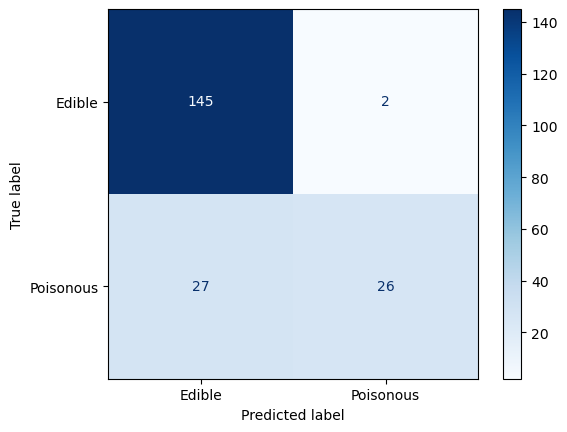

In [179]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_y, pred_y)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=["Edible", "Poisonous"])
disp.plot(cmap=plt.cm.Blues).figure_.savefig("cm.svg")

## CNN Metrics

In [192]:
tp = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tn = cm[1][1]

accuracy = (tp + tn) / (tp + tn + fn + fp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = (precision *  recall) / (precision + recall)
f1 *= 2

print(accuracy, precision, recall, f1)

0.855 0.9863945578231292 0.8430232558139535 0.9090909090909091


## Tensorboard Test

In [ ]:
import tensorflow as tf
import datetime, os

mnist = tf.keras.datasets.mnist

fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

def create_model():
  return tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28), name='layers_flatten'),
    tf.keras.layers.Dense(512, activation='relu', name='layers_dense'),
    tf.keras.layers.Dropout(0.2, name='layers_dropout'),
    tf.keras.layers.Dense(10, activation='softmax', name='layers_dense_2')
  ])

def train_model():

  model = create_model()
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, update_freq='batch')  

  model.fit(x=x_train, y=y_train, epochs=5, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])

train_model()

## Alternative to Tensorboard logging

In [ ]:
from tensorflow.keras.callbacks import Callback

class StepLogger(Callback):

    def __init__(self, logs={}):
        self.a = []
        
    def on_train_batch_end(self, batch, logs={}):
        self.a.append(logs["accuracy"])